In [2]:
import pandas as pd
from utils import (get_data, display_results,
                   get_label_encoder, get_train_dev_test)

# Exploration

In [3]:
df = get_data()
for i in df["Lang"].unique():
    df[df["Lang"] == i].to_csv(f"data/{i}.csv", index=False)

In [4]:
lang = df["Lang"].unique()
lang

array(['GER', 'TUR', 'CHI', 'TEL', 'ARA', 'SPA', 'HIN', 'JPN', 'KOR',
       'FRE', 'ITA'], dtype=object)

In [5]:
lang = df["Lang"].unique()
res = {}
for l in lang:
    res[l] = {}

for i in df["Lang"].unique():
    res[i]["nb"] = df[df["Lang"] == i]["Lang"].count()
    res[i]["moy length"] = df[df["Lang"] == i]["Text"].str.len().mean()
    res[i]["max length"] = df[df["Lang"] == i]["Text"].str.len().max()
    res[i]["min length"] = df[df["Lang"] == i]["Text"].str.len().min()
    res[i]["esperance length"] = df[df["Lang"] == i]["Text"].str.len().std()
    res[i]["moy nb mot"] = df[df["Lang"] == i]["Text"].str.split().str.len().mean()
    res[i]["max nb mot"] = df[df["Lang"] == i]["Text"].str.split().str.len().max()
    res[i]["min nb mot"] = df[df["Lang"] == i]["Text"].str.split().str.len().min()
    res[i]["esperance nb mot"] = df[df["Lang"] == i]["Text"].str.split().str.len().std()
    res[i]["moy nb phrase"] = df[df["Lang"] == i]["Text"].str.split(".").str.len().mean()
    res[i]["max nb phrase"] = df[df["Lang"] == i]["Text"].str.split(".").str.len().max()
    res[i]["min nb phrase"] = df[df["Lang"] == i]["Text"].str.split(".").str.len().min()
    res[i]["esperance nb phrase"] = df[df["Lang"] == i]["Text"].str.split(".").str.len().std()
    

    print(  
        "lang =", i, ", nb=", round(df[df["Lang"] == i]["Lang"].count(), 3), 
        ", moy length=", round(df[df["Lang"] == i]["Text"].str.len().mean(), 3), 
        ", max length=", round(df[df["Lang"] == i]["Text"].str.len().max(), 3),
        ", min length=", round(df[df["Lang"] == i]["Text"].str.len().min(), 3),
        ", esperance length=", round(df[df["Lang"] == i]["Text"].str.len().std(), 3),
        ", moy nb mot :", round(df[df["Lang"] == i]["Text"].str.split().str.len().mean(), 3),
        ", max nb mot:", round(df[df["Lang"] == i]["Text"].str.split().str.len().max(), 3),
        ", min nb mot:", round(df[df["Lang"] == i]["Text"].str.split().str.len().min(), 3),
        ", esperance nb mot:", round(df[df["Lang"] == i]["Text"].str.split().str.len().std(), 3),
        ", moy nb phrase:", round(df[df["Lang"] == i]["Text"].str.split(".").str.len().mean(), 3),
        ", max nb phrase:", round(df[df["Lang"] == i]["Text"].str.split(".").str.len().max(), 3),
        ", min nb phrase:", round(df[df["Lang"] == i]["Text"].str.split(".").str.len().min(), 3),
        ", esperance nb phrase:", round(df[df["Lang"] == i]["Text"].str.split(".").str.len().std(), 3),
    )


lang = GER , nb= 900 , moy length= 1953.983 , max length= 4142 , min length= 334 , esperance length= 367.666 , moy nb mot : 376.533 , max nb mot: 806 , min nb mot: 63 , esperance nb mot: 69.772 , moy nb phrase: 18.434 , max nb phrase: 40 , min nb phrase: 5 , esperance nb phrase: 4.336
lang = TUR , nb= 900 , moy length= 1842.998 , max length= 4155 , min length= 69 , esperance length= 437.412 , moy nb mot : 352.671 , max nb mot: 776 , min nb mot: 15 , esperance nb mot: 83.303 , moy nb phrase: 18.611 , max nb phrase: 44 , min nb phrase: 1 , esperance nb phrase: 5.567
lang = CHI , nb= 900 , moy length= 1853.389 , max length= 4621 , min length= 92 , esperance length= 432.715 , moy nb mot : 361.812 , max nb mot: 876 , min nb mot: 16 , esperance nb mot: 82.095 , moy nb phrase: 18.448 , max nb phrase: 38 , min nb phrase: 2 , esperance nb phrase: 5.329
lang = TEL , nb= 900 , moy length= 1901.13 , max length= 4074 , min length= 748 , esperance length= 386.245 , moy nb mot : 359.039 , max nb mot:

In [6]:
df["length"] = df["Text"].str.len()
df["mot"] = df["Text"].str.split().str.len()
df["phrase"] = df["Text"].str.split(".").str.len()

# Machine learning

## Implémentations

### imports

In [3]:
# modèles
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import numpy as np
import plotly.express as px

### Generic Function to test a model and vectorizer

In [17]:
def train_one_model(vectorizer, model, labels, label_encoder, X_train, y_train, X_dev, y_dev, X_test, y_test, draw=False):

    X_train_vect = vectorizer.fit_transform(X_train)
    X_dev_vect = vectorizer.transform(X_dev)
    X_test_vect = vectorizer.transform(X_test)

    y_train_labels = label_encoder.transform(y_train)
    y_dev_labels = label_encoder.transform(y_dev)
    y_test_labels = label_encoder.transform(y_test)
    scaler = preprocessing.StandardScaler(with_mean=False).fit(X_train_vect)
    X_scaled_train = scaler.transform(X_train_vect)

    model.fit(X_scaled_train, y_train_labels)

    X_dev_scaled = scaler.transform(X_dev_vect)
    y_pred_dev = model.predict(X_dev_scaled)
    accuracy_dev = accuracy_score(y_dev_labels, y_pred_dev)
    print(f"Accuracy DEV {vectorizer} et {model}: {accuracy_dev:.3f}")
    display_results(y_dev_labels, y_pred_dev, labels, draw)
    
    X_test_scaled = scaler.transform(X_test_vect)
    y_pred_test = model.predict(X_test_scaled)

    # Calcul de l'accuracy sur les données de test
    accuracy_test = accuracy_score(y_test_labels, y_pred_test)
    print(f"Accuracy TEST {vectorizer} et {model}: {accuracy_test:.3f}")
    display_results(y_test_labels, y_pred_test, labels, draw)

## Logistic Regression on the whole dataset

In [19]:

df = get_data()
X = df["Text"]
y = df["Lang"]

X_train, X_dev, X_test, y_train, y_dev, y_test = get_train_dev_test(X, y)
label_encoder, labels = get_label_encoder(df["Lang"])

train_one_model(CountVectorizer(), LogisticRegression(), labels, label_encoder, X_train, y_train, X_dev, y_dev, X_test, y_test, draw=True)

Accuracy DEV CountVectorizer() et LogisticRegression(): 0.614


Accuracy  0.6141414141414141
Precision - macro
precision score  0.6130017089704766
Recall - macro
recall score  0.6179256740130977
F1 - macro
f1 score  0.6104025820214214
Accuracy TEST CountVectorizer() et LogisticRegression(): 0.624


Accuracy  0.6242424242424243
Precision - macro
precision score  0.6256167238331533
Recall - macro
recall score  0.6263419165879139
F1 - macro
f1 score  0.6231709371472025


## Logistic Regression on CHI KOR JAP

In [23]:
df_chi = pd.read_csv("data/CHI.csv")
df_kor = pd.read_csv("data/KOR.csv")
df_jap = pd.read_csv("data/JPN.csv")

df_concat = pd.concat([df_chi, df_kor, df_jap])
X = df_concat["Text"]
y = df_concat["Lang"]

X_train, X_dev, X_test, y_train, y_dev, y_test = get_train_dev_test(X, y)
label_encoder, labels = get_label_encoder(df_concat["Lang"])
train_one_model(CountVectorizer(), LogisticRegression(), labels, label_encoder, X_train, y_train, X_dev, y_dev, X_test, y_test, draw=True)

Accuracy DEV CountVectorizer() et LogisticRegression(): 0.641


Accuracy  0.6407407407407407
Precision - macro
precision score  0.6413221127954406
Recall - macro
recall score  0.6362768280223609
F1 - macro
f1 score  0.636584439415582
Accuracy TEST CountVectorizer() et LogisticRegression(): 0.722


Accuracy  0.7222222222222222
Precision - macro
precision score  0.7237070389953734
Recall - macro
recall score  0.7213601302920823
F1 - macro
f1 score  0.7214908415053145


## Pipeline

In [7]:
def process_pipeline(pipeline, df, draw=False):
    label_encoder, labels = get_label_encoder(df["Lang"])

    X = df["Text"]
    y = df["Lang"]
    X_train, X_dev, X_test, y_train, y_dev, y_test = get_train_dev_test(X, y)

    y_train_labels = label_encoder.transform(y_train)
    y_dev_labels = label_encoder.transform(y_dev)

    pipeline.fit(X_train, y_train_labels)

    y_pred_dev = pipeline.predict(X_dev)
    display_results(y_dev_labels, y_pred_dev, labels, draw)

In [24]:
# LinearSVC(dual="auto", random_state=0, tol=1e-5)
clf = make_pipeline(
    TfidfVectorizer(), 
    # StandardScaler(with_mean=False),
    #LinearSVC(dual="auto", random_state=0, tol=1e-5),
    #KNeighborsClassifier(n_neighbors=3)
    # LogisticRegression()
    # DecisionTreeClassifier()
    # RandomForestClassifier()
    SGDClassifier()
)

df_chi = pd.read_csv("data/CHI.csv")
df_chi = df_chi.sample(300)
df_kor = pd.read_csv("data/KOR.csv")
df_kor = df_kor.sample(300)
df_jap = pd.read_csv("data/JPN.csv")
df_jap = df_jap.sample(300)
df_asie = pd.concat([df_chi, df_kor, df_jap])
df_asie["Lang"] = "ASI"

df_hin = pd.read_csv("data/HIN.csv")
df_hin = df_hin.sample(450)
df_tel = pd.read_csv("data/TEL.csv")
df_tel = df_tel.sample(450)
df_indian = pd.concat([df_hin, df_tel])
df_indian["Lang"] = "IND"


df_other = get_data(exclude=["HIN", "TEL", "CHI", "JPN", "KOR"])
df_concat = pd.concat([df_other, df_asie, df_indian])
process_pipeline(clf, df_concat, draw=True)

Accuracy  0.7625
Precision - macro
precision score  0.7603715039054635
Recall - macro
recall score  0.7599850774056369
F1 - macro
f1 score  0.7565496503450635


In [25]:
def process_one_vs_all(Lang, clf, draw=False):
    df_other = get_data(exclude=[Lang])
    df_other["Lang"] = "OTH"
    df_other = df_other.sample(900)
    df_spa = get_data(include=[Lang])

    df_concat = pd.concat([df_other, df_spa])
    process_pipeline(clf, df_concat, draw)

In [26]:
clf = make_pipeline(
    CountVectorizer(), 
    # StandardScaler(with_mean=False),
    # LinearSVC(dual="auto", random_state=0, tol=1e-5),
    # KNeighborsClassifier(n_neighbors=3)
    # LogisticRegression()
    # DecisionTreeClassifier()
    # RandomForestClassifier()
    SGDClassifier()
)

for lang in df["Lang"].unique():
    process_one_vs_all(lang, clf, draw=True)

Accuracy  0.8944444444444445
Precision - macro
precision score  0.8949777337951509
Recall - macro
recall score  0.8942462032349673
F1 - macro
f1 score  0.8943629343629345


Accuracy  0.8277777777777777
Precision - macro
precision score  0.8298904927824788
Recall - macro
recall score  0.8273243610322263
F1 - macro
f1 score  0.8273461431356168


Accuracy  0.8388888888888889
Precision - macro
precision score  0.8389328063241107
Recall - macro
recall score  0.8388072601555747
F1 - macro
f1 score  0.8388441233676021


Accuracy  0.8666666666666667
Precision - macro
precision score  0.8667736757624398
Recall - macro
recall score  0.8667736757624398
F1 - macro
f1 score  0.8666666666666667


Accuracy  0.8
Precision - macro
precision score  0.8000987776268675
Recall - macro
recall score  0.8000987776268675
F1 - macro
f1 score  0.8


Accuracy  0.7888888888888889
Precision - macro
precision score  0.7910818531859396
Recall - macro
recall score  0.7893567107050253
F1 - macro
f1 score  0.7886540600667409


Accuracy  0.7888888888888889
Precision - macro
precision score  0.7961904761904761
Recall - macro
recall score  0.787998518335597
F1 - macro
f1 score  0.7872075659532105


Accuracy  0.7944444444444444
Precision - macro
precision score  0.8240841990158556
Recall - macro
recall score  0.7927521916285961
F1 - macro
f1 score  0.788966697297126


Accuracy  0.85
Precision - macro
precision score  0.8509401286491836
Recall - macro
recall score  0.8502901592789234
F1 - macro
f1 score  0.8499583217560434


Accuracy  0.8777777777777778
Precision - macro
precision score  0.8777626867514507
Recall - macro
recall score  0.8777626867514507
F1 - macro
f1 score  0.8777626867514507


Accuracy  0.8722222222222222
Precision - macro
precision score  0.883350331463539
Recall - macro
recall score  0.8712804049882702
F1 - macro
f1 score  0.8710722182429698


# Cross Validation

## Shuffle

In [11]:
for i in df["Lang"].unique():
    df_ara = pd.read_csv(f"data/{i}.csv")
    df_ara.sample(frac=1).reset_index(drop=True).to_csv(f"data/{i}.csv", index=False)

In [12]:
import pandas as pd
import glob
import random

files = glob.glob("data/*.csv")

# Read lines from each file
lines_from_each_file = []
for file_path in files:
    with open(file_path, 'r') as file:
        lines = file.readlines()[1:]
        lines_from_each_file.append(lines)

# Alternate lines from each file with random order in each cycle
combined_lines = []
num_lines = len(lines_from_each_file[0])
for i in range(num_lines):
    # Shuffle the order of files for each line
    random.shuffle(lines_from_each_file)

    # Add one line from each file in the shuffled order
    for lines in lines_from_each_file:
        combined_lines.append(lines[i])

# Create DataFrame
df = pd.DataFrame([line.split(r',"') for line in combined_lines])
df.drop(columns=[2], inplace=True)
df.head(15)


,0,1
0,ITA,I agree that most advertisements make product...
1,FRE,"In my opinion , it is more important for us s..."
2,TUR,I agree with the fact that young people do n'...
3,JPN,I know lots of older people enjoy life after ...
4,SPA,"This is a very extended statement , especiall..."
5,HIN,I disagree with the concept of having a gener...
6,TEL,"No , i disagree , that it is better to have b..."
7,CHI,It will be better to have a knowledge of many...
8,GER,I disagree with the statement . Students have...
9,ARA,Imagin your life without Air ? . Advertisemen...


In [13]:
tel = pd.read_csv("data/TEL.csv")
hin = pd.read_csv("data/HIN.csv")
chi = pd.read_csv("data/CHI.csv")
fre = pd.read_csv("data/FRE.csv")
ita = pd.read_csv("data/ITA.csv")

tel_hin = pd.concat([tel, hin])
tel_hin

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(tel_hin["Text"])
y = tel_hin["Lang"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = preprocessing.StandardScaler(with_mean=False).fit(X_train)
X_scaled = scaler.transform(X_train)

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_scaled, y_train.values.ravel())

# Make predictions on the test set
# scaler = preprocessing.StandardScaler(with_mean=False).fit(X_test)
y_pred = model.predict(scaler.transform(X_test))

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7111111111111111


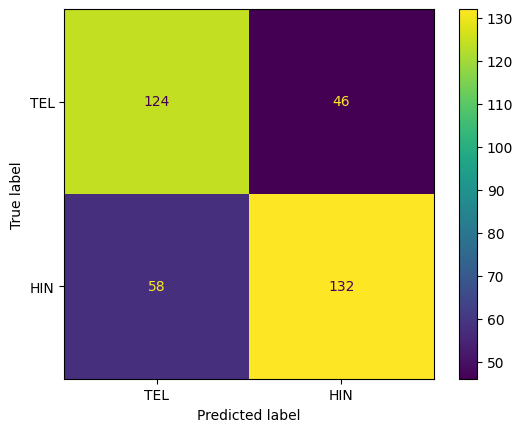

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred, y_test, labels=tel_hin["Lang"].unique()), display_labels=tel_hin["Lang"].unique()).plot()

# SVM

In [15]:
from sklearn.svm import SVC

# Vectorize the text and combine with other numerical features
vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(df['Text'])
X_other_numerical = df[["mot", "length", "phrase"]].values
X_all = hstack((X_text, X_other_numerical))

X_train, X_test, y_train, y_test = train_test_split(X_text, df[["Lang"]], test_size=0.4, random_state=42)

scaler = preprocessing.StandardScaler(with_mean=False).fit(X_train)
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

# Create and train the SVM model
svm_model = SVC()
svm_model.fit(X_scaled_train, y_train.values.ravel())

# Make predictions on the test set
y_pred = svm_model.predict(X_scaled_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


KeyError: 'Text'